<a href="https://colab.research.google.com/github/amoralesc0017/amoralesc0017/blob/main/Sprint_7_1_Project_Statcast_Total_Barrels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

## Assignment

Complete these tasks for your assignment/project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict? Total Barrels
- [ ] Is your problem regression or classification? Regression
- [ ] How is your target distributed? Right skewed
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them? rank, last_name, first_name, year, average_homerun
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information? barrels_plate_appearance_percentage, barrels_batted_balls_percentage


If you haven't found a dataset yet, do that today. Review requirements for your portfolio project on Canvas, and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving statcast.csv to statcast (1).csv


In [4]:
%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*
!pip install ydata-profiling

In [5]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder

In [6]:
statcast = pd.read_csv('statcast.csv', index_col = 'id')

In [7]:
statcast.head()

,rank,year,last_name,first_name,launch_angle,sweet_spot_percentage,max_ev,average_ev,fly_ball_line_drive_ev,ground_ball_ev,max_distance,average_distance,average_homerun,hard_hit_95mph+,hard_hit_percentage,hard_hit_swing_percentage,total_barrels,barrels_batted_balls_percentage,barrels_plate_appearance_percentage
id,,,,,,,,,,,,,,,,,,,
1,1,2022,Judge,Aaron,14.6,37.8,118.4,95.8,100.2,89.1,465,205,413.0,210,61.6,20.3,91,26.7,15.8
2,2,2022,Alvarez,Yordan,12.1,40.1,117.4,95.5,98.2,92.7,469,193,403.0,186,61.2,23.7,59,19.4,12.7
3,3,2022,Trout,Mike,24.7,37.2,114.4,91.7,94.9,87.7,472,218,407.0,120,51.3,16.5,46,19.7,11.6
4,4,2022,Schwarber,Kyle,18.9,34.6,114.8,93.3,99.7,87.2,468,197,415.0,170,54.5,17.6,64,20.5,11.5
5,5,2022,Stanton,Giancarlo,10.2,26.3,119.8,94.6,98.2,94.1,445,160,400.0,117,51.3,17.8,42,18.4,11.3


In [8]:
statcast = statcast.drop(columns=['rank', 'last_name', 'first_name', 'year', 'average_homerun', 'barrels_plate_appearance_percentage', 'barrels_batted_balls_percentage'])


In [9]:
statcast.head()

,launch_angle,sweet_spot_percentage,max_ev,average_ev,fly_ball_line_drive_ev,ground_ball_ev,max_distance,average_distance,hard_hit_95mph+,hard_hit_percentage,hard_hit_swing_percentage,total_barrels
id,,,,,,,,,,,,
1,14.6,37.8,118.4,95.8,100.2,89.1,465,205,210,61.6,20.3,91
2,12.1,40.1,117.4,95.5,98.2,92.7,469,193,186,61.2,23.7,59
3,24.7,37.2,114.4,91.7,94.9,87.7,472,218,120,51.3,16.5,46
4,18.9,34.6,114.8,93.3,99.7,87.2,468,197,170,54.5,17.6,64
5,10.2,26.3,119.8,94.6,98.2,94.1,445,160,117,51.3,17.8,42


In [10]:
statcast.isnull().sum()

launch_angle                 0
sweet_spot_percentage        0
max_ev                       0
average_ev                   0
fly_ball_line_drive_ev       0
ground_ball_ev               0
max_distance                 0
average_distance             0
hard_hit_95mph+              0
hard_hit_percentage          0
hard_hit_swing_percentage    0
total_barrels                0
dtype: int64

In [11]:
statcast.shape

(1983, 12)

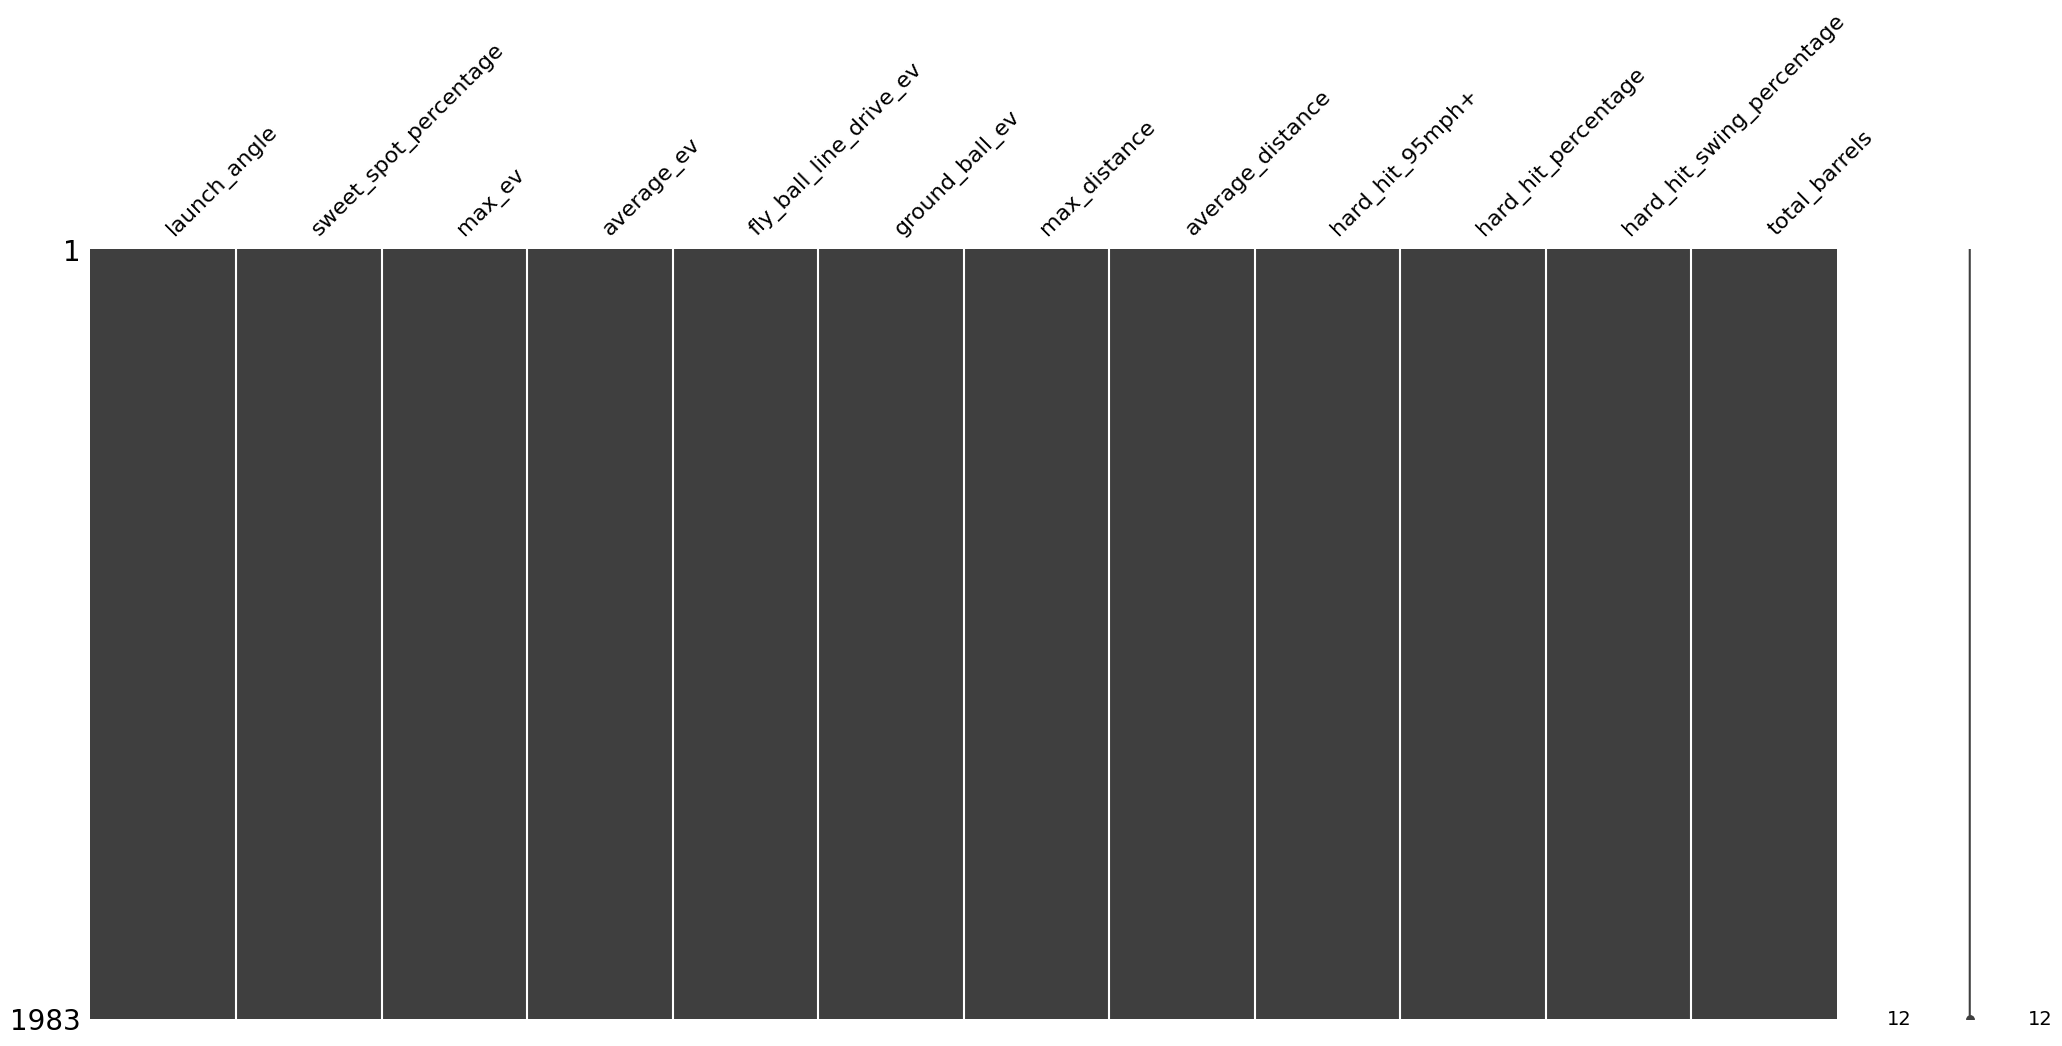

In [12]:
import matplotlib.pyplot as plt
import missingno as msno
msno.matrix(statcast)

plt.show()

<Axes: >

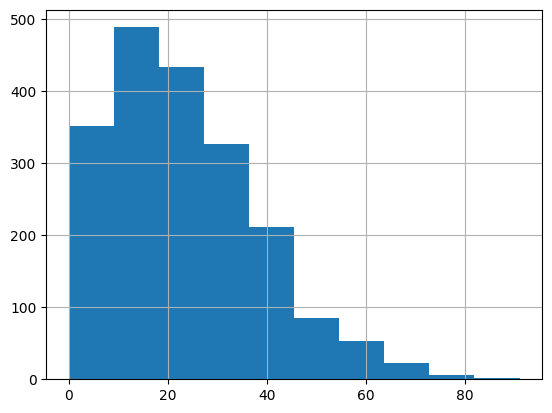

In [13]:
statcast['total_barrels'].hist()

In [14]:
target = 'total_barrels'
y = statcast[target]
X = statcast.drop(columns = target)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [16]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.03530895334174023


In [17]:
model_lr = make_pipeline(
    LinearRegression()
    )

model_lr = model_lr.fit(X_train, y_train)

In [18]:
print(model_lr.score(X_train, y_train))
print(model_lr.score(X_test, y_test))

0.8533406154829886
0.8644479409710879


In [19]:
model_rf = make_pipeline(
    RandomForestRegressor()
)

model_rf = model_rf.fit(X_train, y_train)

In [20]:
print(model_rf.score(X_train, y_train))
print(model_rf.score(X_test, y_test))

0.9837585428751763
0.8956918602986982


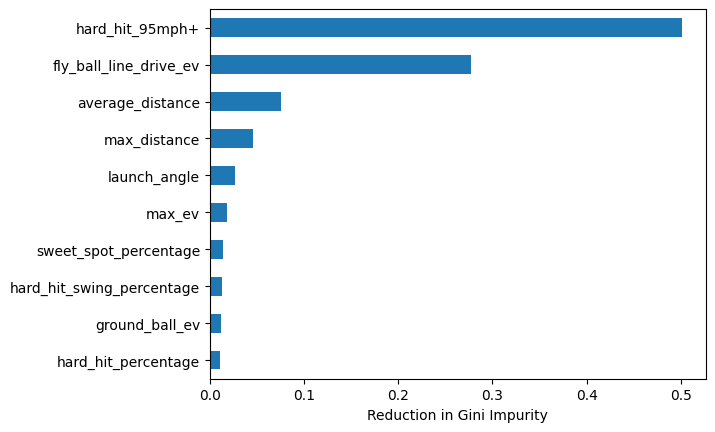

In [21]:
importances = model_rf.named_steps['randomforestregressor'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

In [25]:
y_pred = model_lr.predict(X)
statcast['y_pred'] = y_pred
statcast.head()

,launch_angle,sweet_spot_percentage,max_ev,average_ev,fly_ball_line_drive_ev,ground_ball_ev,max_distance,average_distance,hard_hit_95mph+,hard_hit_percentage,hard_hit_swing_percentage,total_barrels,y_pred
id,,,,,,,,,,,,,
1,14.6,37.8,118.4,95.8,100.2,89.1,465,205,210,61.6,20.3,91,63.167365
2,12.1,40.1,117.4,95.5,98.2,92.7,469,193,186,61.2,23.7,59,45.898721
3,24.7,37.2,114.4,91.7,94.9,87.7,472,218,120,51.3,16.5,46,37.948678
4,18.9,34.6,114.8,93.3,99.7,87.2,468,197,170,54.5,17.6,64,52.931935
5,10.2,26.3,119.8,94.6,98.2,94.1,445,160,117,51.3,17.8,42,31.432181


In [27]:
from sklearn import metrics
import numpy as np
mse = metrics.mean_squared_error(y, statcast['y_pred'])
mae = metrics.mean_absolute_error(y, statcast['y_pred'])
rmse = np.sqrt(mse)
print(mse, mae, rmse)

KeyError: ignored